In [16]:
import pandas as pd
import numpy as np 
import os 
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc 
import time 
from glob import glob 
from IPython.display import display 
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
from wordcloud import WordCloud 
from typing import Dict 

warnings.simplefilter("ignore")
plt.style.use("dark_background")
np.random.seed(42)
debug = True

# 0. Read CSV 

In [17]:
%%time 


district = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")
district.drop("county_connections_ratio", axis=1, inplace=True)
product = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv", usecols=["LP ID", "Product Name", "Primary Essential Function"])

engagement = pd.DataFrame()
for i, f in enumerate(glob("../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/*.csv")):
    df = pd.read_csv(f)
    district_id = f.split("/")[-1].split(".")[0]
    df["district_id"] = district_id 
#     df["engagement_index"] = df["engagement_index"].fillna(df["engagement_index"].mean())
    df["pct_access"] = df["pct_access"].fillna(df["pct_access"].mean())
    engagement = pd.concat([engagement, df])
    if debug:
        if i > 30:
            break 
    else:
        if i > 233:
            break 
        
display(district.head())
display(product.head())
display(engagement.head())


,district_id,state,locale,pct_black/hispanic,pct_free/reduced,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN


,LP ID,Product Name,Primary Essential Function
0,13117,SplashLearn,LC - Digital Learning Platforms
1,66933,ABCmouse.com,LC - Digital Learning Platforms
2,50479,ABCya!,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,ALEKS,LC - Digital Learning Platforms
4,73104,Achieve3000,LC - Digital Learning Platforms


,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,92844.0,0.01,0.68,6345
1,2020-01-01,64838.0,0.01,0.68,6345
2,2020-01-01,94058.0,0.00,NaN,6345
3,2020-01-01,26488.0,0.03,26.21,6345
4,2020-01-01,32340.0,0.01,0.11,6345


CPU times: user 5.14 s, sys: 1.97 s, total: 7.11 s
Wall time: 8.02 s


In [18]:
display(district.isnull().sum().to_frame())

,0
district_id,0
state,57
locale,57
pct_black/hispanic,57
pct_free/reduced,85
pp_total_raw,115


# 1. Preprocess 

In [19]:
'''
district table 
'''

def pct_black(x):
    if x == "[0, 0.2[":
        return float(0.1)
    elif x == "[0.2, 0.4[":
        return float(0.3)
    elif x == "[0.4, 0.6[":
        return float(0.5)
    elif x == "[0.8, 1[":
        return float(0.9)
    else:
        return np.nan
    
def pct_free(x):
    if x == "[0, 0.2[":
        return float(0.1)
    elif x == "[0.2, 0.4[":
        return float(0.3)
    elif x == "[0.4, 0.6[":
        return float(0.5)
    elif x == "[0.6, 0.8[":
        return float(0.7)
    elif x == "[0.8, 1[":
        return float(0.9)
    else:
        return np.nan 
    
def pp_raw(x):
    if x == "missing":
        return x 
    else:
        x = str(x)
        upper_value = int(x.split(",")[0].split("[")[1].strip())
        lower_value = int(x.split(",")[1].split("[")[0].strip())
        return (upper_value+lower_value) // 2 
    
# drppna
district = district[district.state.notna()].reset_index(drop=True)

# take the median as float 
district["pct_black/hispanic"] = district["pct_black/hispanic"].apply(pct_black)
district["pct_free/reduced"] = district["pct_free/reduced"].apply(pct_free)
district["pp_total_raw"] = district["pp_total_raw"].fillna("missing")
district["pp_total_raw"] = district["pp_total_raw"].apply(pp_raw)

# fill values 
district["pct_black/hispanic"] = district["pct_black/hispanic"].fillna(district[district["pct_black/hispanic"].notna()].groupby("locale")["pct_black/hispanic"].mean())
district["pct_black/hispanic"] = district["pct_black/hispanic"].fillna(district["pct_black/hispanic"].mean())
district["pct_free/reduced"] = district["pct_free/reduced"].fillna(district[district["pct_free/reduced"].notna()].groupby("locale")["pct_free/reduced"].mean())
district["pct_free/reduced"] = district["pct_free/reduced"].fillna(district["pct_free/reduced"].mean())
district["pp_total_raw"] = district["pp_total_raw"].apply(lambda x: district.loc[district["pp_total_raw"] != "missing", "pp_total_raw"].mean() if x == "missing" else x)

display(district.isnull().sum().to_frame())

,0
district_id,0
state,0
locale,0
pct_black/hispanic,0
pct_free/reduced,0
pp_total_raw,0


In [20]:

'''
product table 

'''

def get_main(x):
    if type(x) == list and len(x) > 0 :
        return x[0] 
    else:
        return "missing"
    
def get_sub(x):
    if type(x) == list and len(x) > 1:
        return x[1]
    else:
        return "missing"
    
# split main and sub in Primary Essential Function    
product["Primary Essential Function"] = product["Primary Essential Function"].fillna("missing")
product["split"] = product["Primary Essential Function"].apply(lambda x: x.split("-"))
product["main"] = product["split"].apply(get_main)
product["sub"] = product["split"].apply(get_sub)
product.drop(["split", "Primary Essential Function"], axis=1, inplace=True)

display(product.isnull().sum().to_frame())

,0
LP ID,0
Product Name,0
main,0
sub,0


In [21]:

'''
merge dataframe 

'''

df = pd.merge(engagement, product, how="left", left_on="lp_id", right_on="LP ID")
del engagement, product

df["district_id"] = df["district_id"].astype(int)
district["district_id"] = district["district_id"].astype(int)
df = pd.merge(df, district, how="left", left_on="district_id", right_on="district_id")
del district 
gc.collect()

if debug:
    df = df.dropna()
    
df = df.rename(columns={"Product Name": "product", "pct_black/hispanic": "hispanic", "pct_free/reduced": "reduced", "pp_total_raw": "pp_raw"})
df.drop("LP ID", axis=1, inplace=True)
df.head()

,time,lp_id,pct_access,engagement_index,district_id,product,main,sub,state,locale,hispanic,reduced,pp_raw
0,2020-01-01,92844.0,0.01,0.68,6345,Typing.com,LC,Digital Learning Platforms,Massachusetts,Suburb,0.3,0.339189,13000.0
1,2020-01-01,64838.0,0.01,0.68,6345,Starfall,LC,"Sites, Resources & Reference",Massachusetts,Suburb,0.3,0.339189,13000.0
4,2020-01-01,32340.0,0.01,0.11,6345,Education Genius,missing,missing,Massachusetts,Suburb,0.3,0.339189,13000.0
5,2020-01-01,95731.0,0.20,40.96,6345,Google Docs,LC,Content Creation & Curation,Massachusetts,Suburb,0.3,0.339189,13000.0
6,2020-01-01,92918.0,0.01,4.54,6345,College Compass,missing,missing,Massachusetts,Suburb,0.3,0.339189,13000.0


In [22]:
display(df.isnull().sum().to_frame())

,0
time,0
lp_id,0
pct_access,0
engagement_index,0
district_id,0
product,0
main,0
sub,0
state,0
locale,0


In [23]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

In [24]:
%%time

df = reduce_mem_usage(df)
df["time"] = pd.to_datetime(df.time)

Memory usage of dataframe is 101.10 MB
Memory usage after optimization is: 30.71 MB
Decreased by 69.6%
CPU times: user 604 ms, sys: 575 µs, total: 604 ms
Wall time: 606 ms


# 2.EDA 

## Numerical data 
---

### Plattoform x Numerical 
Only the most used or unused products are counted. 

126

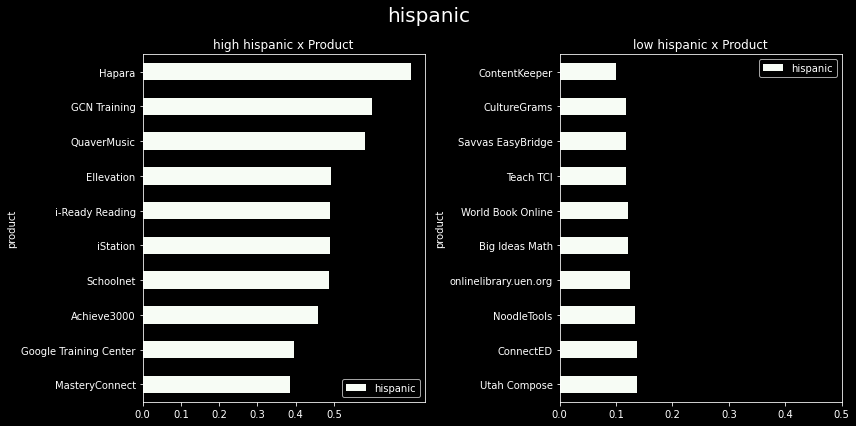

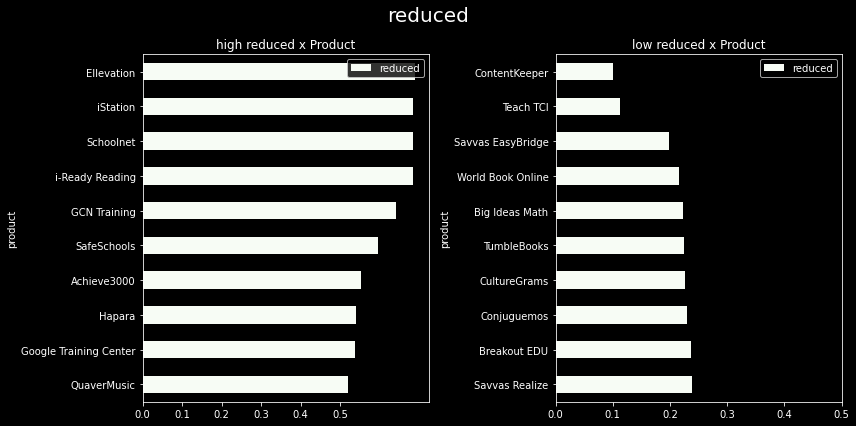

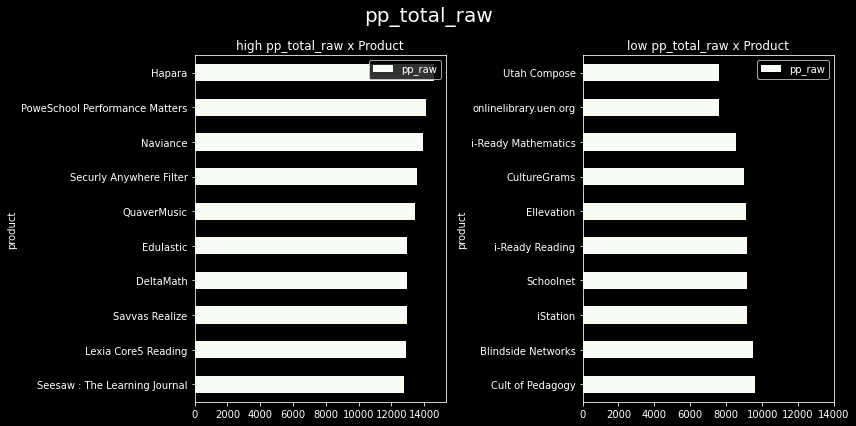

In [25]:
#hispanic 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

hispanic = df.groupby("product").mean().loc[:, ["hispanic"]].sort_values("hispanic", ascending=False)
hispanic.iloc[:10].sort_values("hispanic").plot(kind="barh", cmap="Greens", ax=ax[0])
ax[0].set_title("high hispanic x Product")
ax[0].set_xticks(np.arange(0, 0.6, 0.1))
hispanic.iloc[-10:].sort_values("hispanic", ascending=False).plot(kind="barh", cmap="Greens", ax=ax[1])
ax[1].set_title("low hispanic x Product")
ax[1].set_xticks(np.arange(0, 0.6, 0.1))
plt.suptitle("hispanic", fontsize=20)
plt.tight_layout()

#reduces 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

hispanic = df.groupby("product").mean().loc[:, ["reduced"]].sort_values("reduced", ascending=False)
hispanic.iloc[:10].sort_values("reduced").plot(kind="barh", cmap="Greens", ax=ax[0])
ax[0].set_title("high reduced x Product")
ax[0].set_xticks(np.arange(0, 0.6, 0.1))
hispanic.iloc[-10:].sort_values("reduced", ascending=False).plot(kind="barh", cmap="Greens", ax=ax[1])
ax[1].set_title("low reduced x Product")
ax[1].set_xticks(np.arange(0, 0.6, 0.1))
plt.suptitle("reduced", fontsize=20)
plt.tight_layout()

#pp_total_raw 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

hispanic = df.groupby("product").mean().loc[:, ["pp_raw"]].sort_values("pp_raw", ascending=False)
hispanic.iloc[:10].sort_values("pp_raw").plot(kind="barh", cmap="Greens", ax=ax[0])
ax[0].set_title("high pp_total_raw x Product")
ax[0].set_xticks(np.arange(0, 16000, 2000))
hispanic.iloc[-10:].sort_values("pp_raw", ascending=False).plot(kind="barh", cmap="Greens", ax=ax[1])
ax[1].set_title("low pp_total_raw x Product")
ax[1].set_xticks(np.arange(0, 16000, 2000))
plt.suptitle("pp_total_raw", fontsize=20)
plt.tight_layout()

del hispanic 
gc.collect()

### Locale x Numerical 

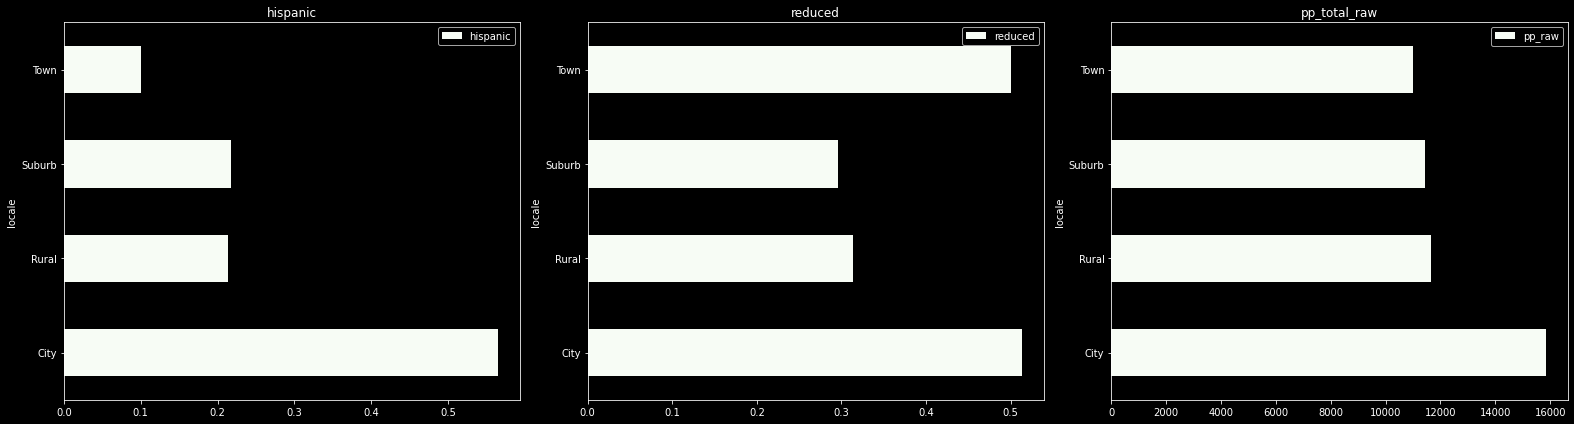

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
ax = axes.ravel()

grp = df.groupby("locale").mean().loc[:, ["hispanic"]]
grp.plot(kind="barh", cmap="Greens", ax=ax[0])
ax[0].set_title("hispanic")

grp = df.groupby("locale").mean().loc[:, ["reduced"]]
grp.plot(kind="barh", cmap="Greens", ax=ax[1])
ax[1].set_title("reduced")

grp = df.groupby("locale").mean().loc[:, ["pp_raw"]]
grp.plot(kind="barh", cmap="Greens", ax=ax[2])
ax[2].set_title("pp_total_raw")

plt.tight_layout()


### Locale x Plattform
Get popular platforms in each locale

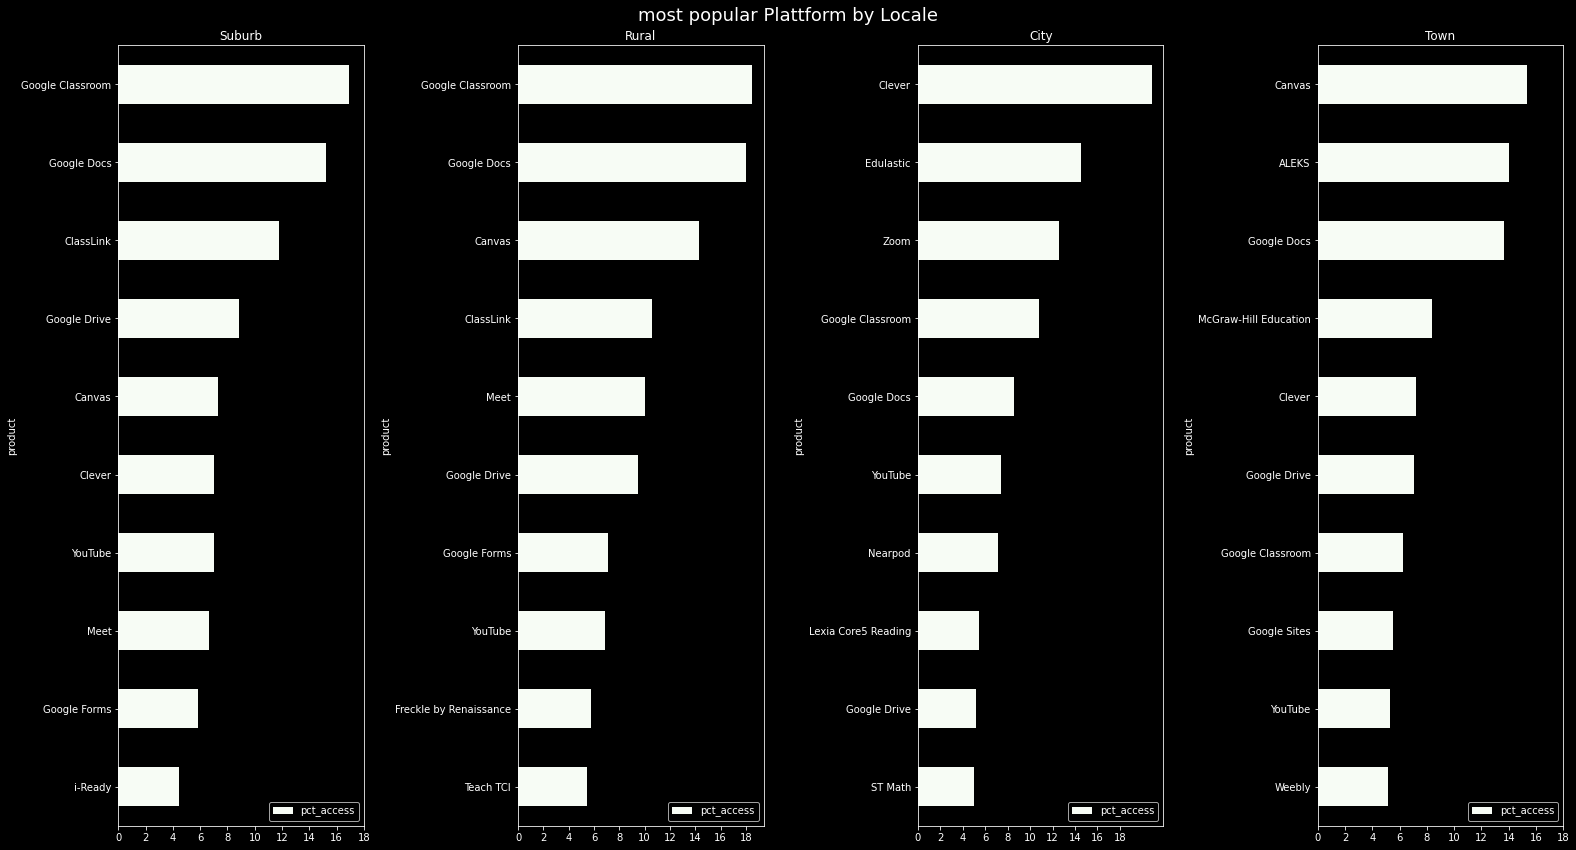

In [27]:
locale = df.locale.value_counts().index
fig, axes = plt.subplots(1, 4, figsize=(22, 12))
ax = axes.ravel()

# locale 1
grp = df.loc[df.locale == locale[0], ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:10]
grp.sort_values("pct_access").plot(kind="barh", ax=ax[0], cmap="Greens")
ax[0].set_title(locale[0])
ax[0].set_xticks(np.arange(0, 20.0, 2.0))


# locale 2 
grp = df.loc[df.locale == locale[1], ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:10]
grp.sort_values("pct_access").plot(kind="barh", ax=ax[1], cmap="Greens")
ax[1].set_title(locale[1])
ax[1].set_xticks(np.arange(0, 20.0, 2.0))


# locale 3 
grp = df.loc[df.locale == locale[2], ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:10]
grp.sort_values("pct_access").plot(kind="barh", ax=ax[2], cmap="Greens")
ax[2].set_title(locale[2])
ax[2].set_xticks(np.arange(0, 20.0, 2.0))


# locale 4
grp = df.loc[df.locale == locale[3], ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:10]
grp.sort_values("pct_access").plot(kind="barh", ax=ax[3], cmap="Greens")
ax[3].set_title(locale[3])
ax[3].set_xticks(np.arange(0, 20.0, 2.0))

del grp 
gc.collect()
plt.suptitle("most popular Plattform by Locale", fontsize=18)
plt.tight_layout()

#### Obsevation... 
* The google platform shows high frequency of use in every area. 
* Especially in city, the ratio of hispanic is large and the ratio is also high from the total of platforms.   
* Most consist of city or suburb.   
* Extreme pp_total_raw platform not included in popularity   

Continue your insights from the three figures above. You will get a better analysis. 

###   Popular Plattform 
---

#### all 

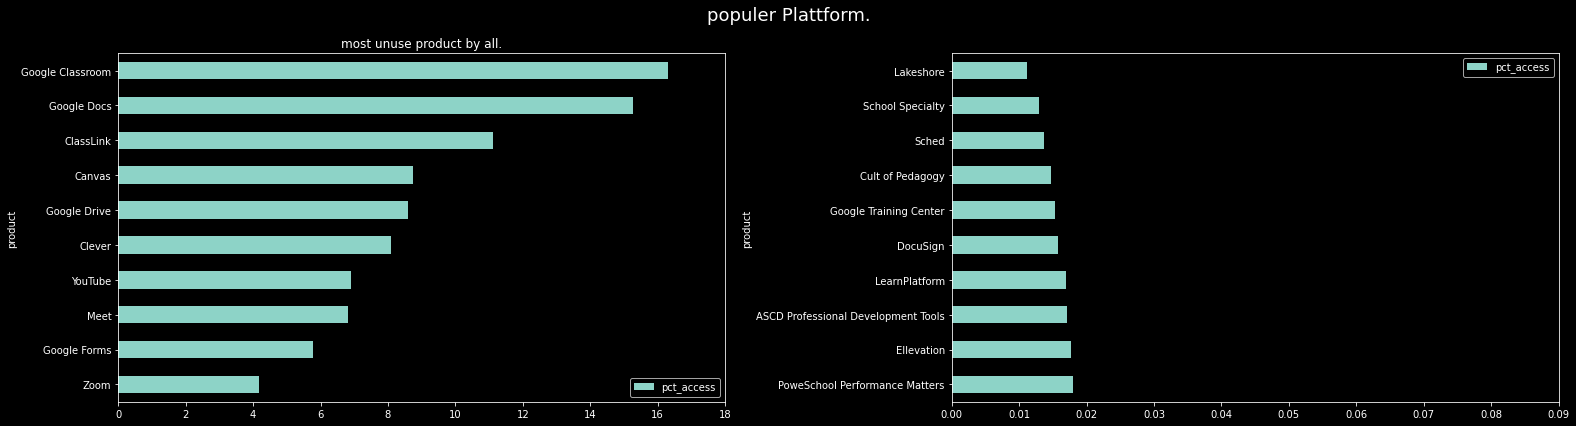

In [28]:
grp = df.groupby("product").mean().loc[:, ["pct_access"]]

fig, axes = plt.subplots(1, 2, figsize=(22, 6))
ax = axes.ravel()

grp.sort_values("pct_access", ascending=False)[:10].sort_values("pct_access", ascending=True).plot(kind="barh", ax=ax[0])
ax[0].set_title("most use product by all.")
ax[0].set_xticks(np.arange(0, 20.0, 2.0))

grp.sort_values("pct_access", ascending=True)[:10].sort_values("pct_access", ascending=False).plot(kind="barh", ax=ax[1])
ax[0].set_title("most unuse product by all.")
ax[1].set_xticks(np.arange(0, 0.1, 0.01))

plt.suptitle("populer Plattform.", fontsize=18)
plt.tight_layout()

#### weekly

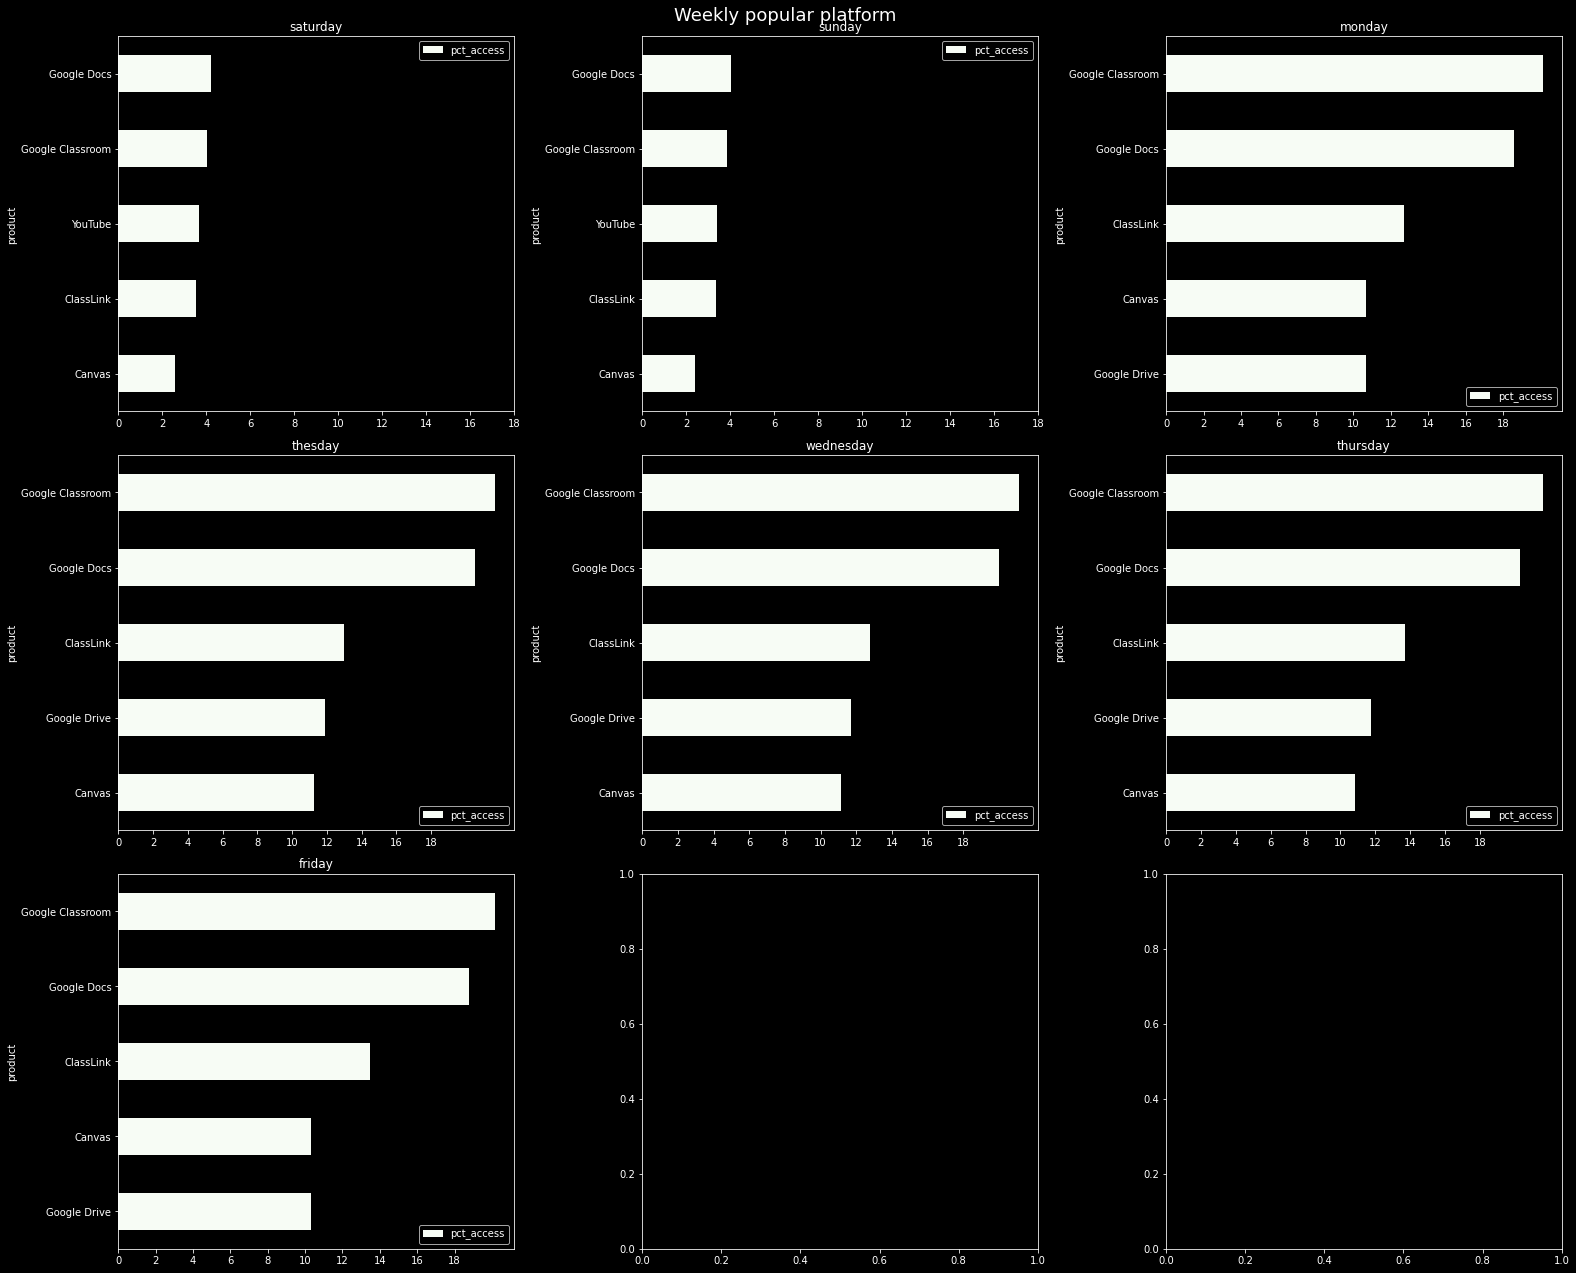

In [29]:
df["week"] = df.time.dt.dayofweek 

week_name = {
    0: "monday", 
    1: "thesday",
    2: "wednesday", 
    3: "thursday", 
    4: "friday",
    5: "saturday",
    6: "sunday",
}

fig, axes = plt.subplots(3, 3, figsize=(22, 18))
ax = axes.ravel()

for i, week in enumerate(np.argsort(df.week.unique())):
    x = df.loc[df.week == week, ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:5]
    x.sort_values("pct_access", ascending=True).plot(kind="barh", cmap="Greens", ax=ax[i])
    ax[i].set_title(week_name[week])
    ax[i].set_xticks(np.arange(0, 20.0, 2.0))
    
plt.suptitle("Weekly popular platform ", fontsize=18)
plt.tight_layout()

#### Trends in popular and unpopular platforms 

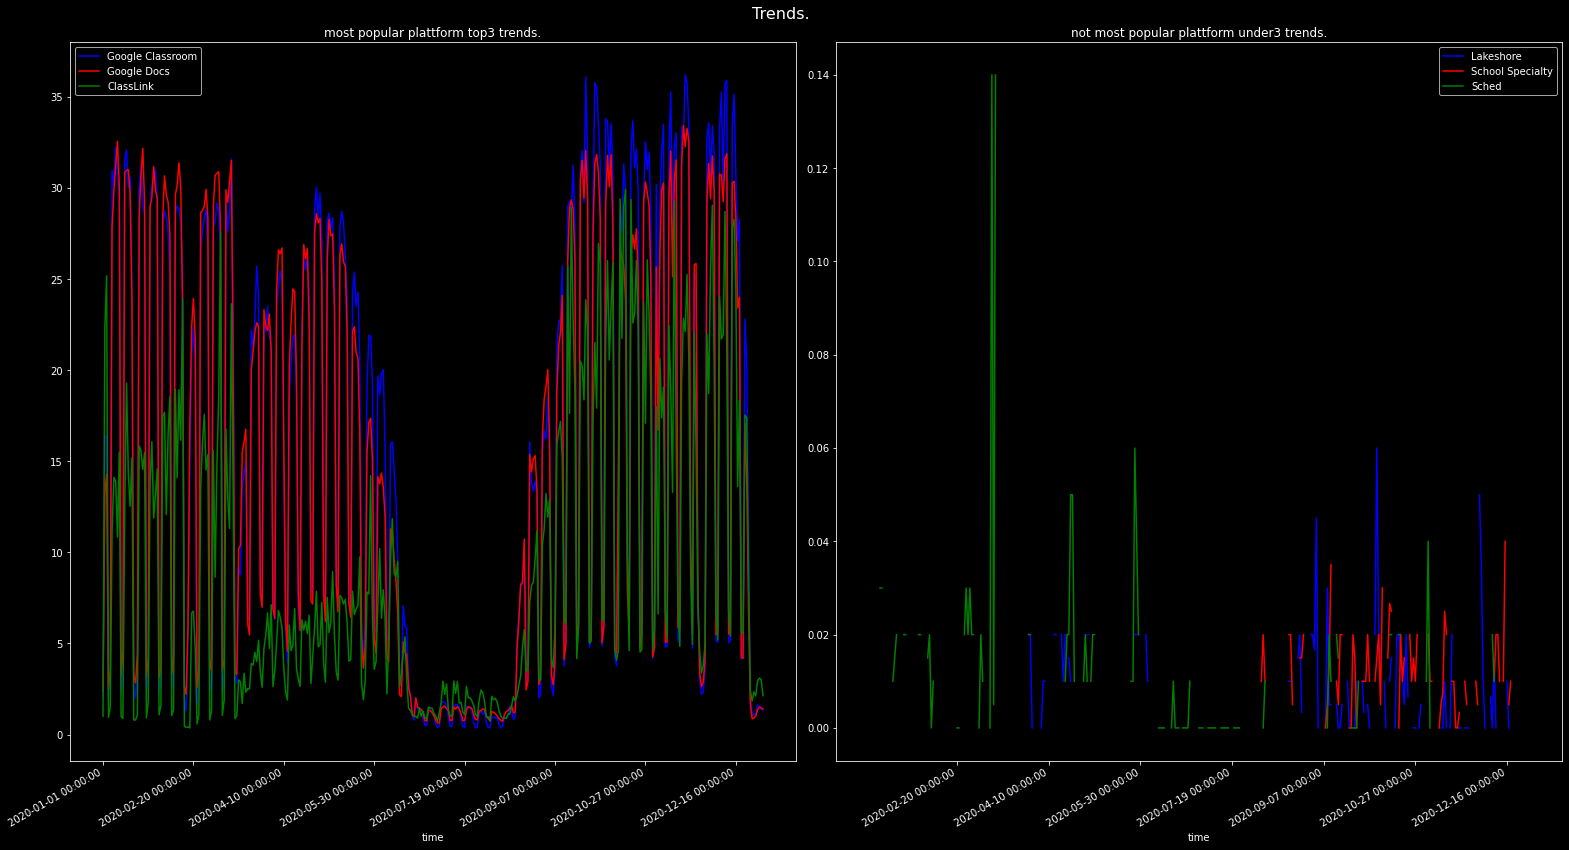

In [30]:
def viz_transition(high, low):
    fig, axes = plt.subplots(1, 2, figsize=(22, 12))
    ax = axes.ravel()
    color = ["b", "r", "g"]
    for i, p in enumerate(high):
        x = df[df["product"] == p]
        x[["time", "pct_access"]].groupby("time").mean().loc[:, "pct_access"].plot(cmap="Greens", ax=ax[0], color=color[i])
    ax[0].set_title("most popular plattform top3 trends.")
    ax[0].legend(high)
    
    for i, p in enumerate(low):
        x = df[df["product"] == p]
        x[["time", "pct_access"]].groupby("time").mean().loc[:, "pct_access"].plot(cmap="Greens", ax=ax[1], color=color[i])
    ax[1].set_title("not most popular plattform under3 trends.")
    ax[1].legend(low)
    plt.suptitle("Trends.", fontsize=16)
    plt.tight_layout()
    
    del x
    gc.collect()
    

top_3_plattform = df[["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:3].index.values.to_list()
under_3_plattform = df[["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=True)[:3].index.values.to_list()
viz_transition(top_3_plattform, under_3_plattform)

### Plattform x Locale  
Same as the combination described above, but with different trials to aggregate from each platform. In other words, the aggregated value is reversed.   
Note that the width numbers are 10 times different. 

36127

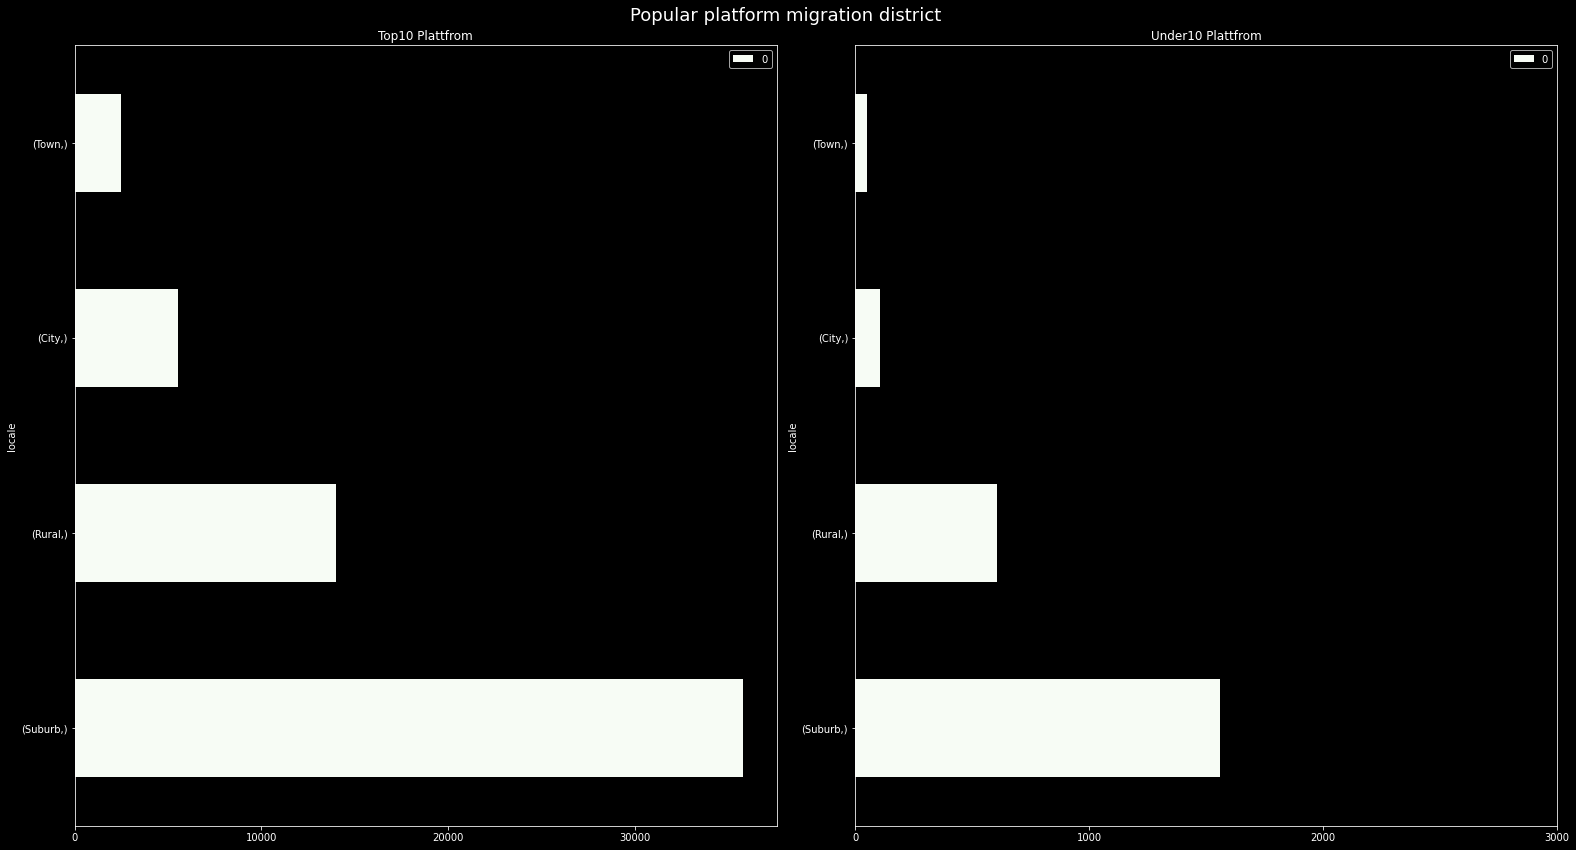

In [31]:
top_10_plattform = df[["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:10].index.values.to_list()
under_10_plattform = df[["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[-10:].index.values.to_list()

fig, axes = plt.subplots(1, 2, figsize=(22, 12))
ax = axes.ravel()

grp = df.loc[df["product"].isin(top_10_plattform), ["locale"]].value_counts().to_frame()
grp.plot(kind="barh", cmap="Greens", ax=ax[0])
ax[0].set_title("Top10 Plattfrom")
ax[0].set_xticks(np.arange(0, 40000, 10000))

grp = df.loc[df["product"].isin(under_10_plattform), ["locale"]].value_counts().to_frame()
grp.plot(kind="barh", cmap="Greens", ax=ax[1])
ax[1].set_title("Under10 Plattfrom")
ax[1].set_xticks(np.arange(0, 4000, 1000))

plt.suptitle("Popular platform migration district ", fontsize=18)
plt.tight_layout()

del grp 
gc.collect()

#### Observation...
* There is a big difference in the transition distribution between popular and unpopular platforms, which is reversed before and after the corona.  
* There is not much change from week to week and google is monopolizing. 
* Platform usage is not sorted by migration type 

However, keep in mind that the axis widths are different.

### Plattform x State

In [32]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

pd.DataFrame({"TOP": top_10_plattform, "UNDER": under_10_plattform})

,TOP,UNDER
0,Google Classroom,PoweSchool Performance Matters
1,Google Docs,Ellevation
2,ClassLink,ASCD Professional Development Tools
3,Canvas,LearnPlatform
4,Google Drive,DocuSign
5,Clever,Google Training Center
6,YouTube,Cult of Pedagogy
7,Meet,Sched
8,Google Forms,School Specialty
9,Zoom,Lakeshore


In [33]:
def show_location(plattform):
    x = df.loc[df["product"].isin(plattform), "state"].value_counts().to_frame().sort_values("state", ascending=False)[:20]
    x = x.rename(columns={"state": "count"})
    x["state"] = x.index 
    x["state"] = x.state.map(us_state_abbrev)
    x = x.reset_index(drop=True)
    data = dict(
        type = 'choropleth',
        colorscale = 'blackbody',
        locations = x["state"],
        locationmode = 'USA-states',
        z = list(x['count']),
        text = x["state"],
        colorbar = {'title':'States'},
      )
    layout = dict(title = 'States',
                  geo = dict(projection = {'type':'mercator'})
                 )
    layout = dict(title= 'Platform popularity usage count ',
                  geo = {'scope':'usa'})

    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap)
    del x
    gc.collect()
    
    
def show_location_locale(locale, plattform):
    x = df.loc[(df["locale"] == locale) & (df["product"].isin(plattform)), ["state", "product"]]
    x = x.groupby("state").count().loc[:, ["product"]]
    x = x[x["product"] != 0]
    x = x.rename(columns={"product": "count"})
    x["state"] = x.index 
    x["state"] = x["state"].map(us_state_abbrev)
    x = x.reset_index(drop=True)
    
    data = dict(
        type = 'choropleth',
        colorscale = 'blackbody',
        locations = x["state"],
        locationmode = 'USA-states',
        z = list(x['count']),
        text = x["state"],
        colorbar = {'title':'States'},
      )
    layout = dict(title = 'States',
                  geo = dict(projection = {'type':'mercator'})
                 )
    layout = dict(title= f'Platform popularity usage count by {locale}',
                  geo = {'scope':'usa'})
    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap)
    del x
    gc.collect()

### Plattform x State 

Count and visualize the states in which each platform ranked in the frame below is used. 

In [34]:
show_location(top_10_plattform)

In [35]:
show_location(under_10_plattform)

### Plattform x State x Locale 
Visualize platform counts aggregated by locale by state. 

#### Top 10 Plattform groupby locale 

In [36]:
show_location_locale(df.locale.unique()[0], top_10_plattform)

In [37]:
show_location_locale(df.locale.unique()[1], top_10_plattform)

In [38]:
show_location_locale(df.locale.unique()[2], top_10_plattform)

In [39]:
show_location_locale(df.locale.unique()[3], top_10_plattform)

#### Under 10 Plattform groupby locale 

In [40]:
show_location_locale(df.locale.unique()[0], under_10_plattform)

In [41]:
show_location_locale(df.locale.unique()[1], under_10_plattform)

In [42]:
show_location_locale(df.locale.unique()[2], under_10_plattform)

In [43]:
show_location_locale(df.locale.unique()[3], under_10_plattform)

### Plattform x Primary Essential Function 

#### main 

In [44]:
def viz_main(high, low):
    fig, axes = plt.subplots(1, 2, figsize=(22, 12))
    ax = axes.ravel()
    x = df.loc[df["product"].isin(high), ["main"]].value_counts()
    ax[0].pie(x=x.values, labels=x.index, startangle=90, autopct="%1.1f%%", shadow=True, counterclock=False)
    ax[0].set_title("most popular Plattfrom x main.")
    
    x = df.loc[df["product"].isin(low), ["main"]].value_counts()
    ax[1].pie(x=x.values, labels=x.index, startangle=90, autopct="%1.1f%%", shadow=True, counterclock=False)
    ax[1].set_title("not most popular Plattfrom x main.")
    
    plt.tight_layout()
    del x 
    gc.collect()
    

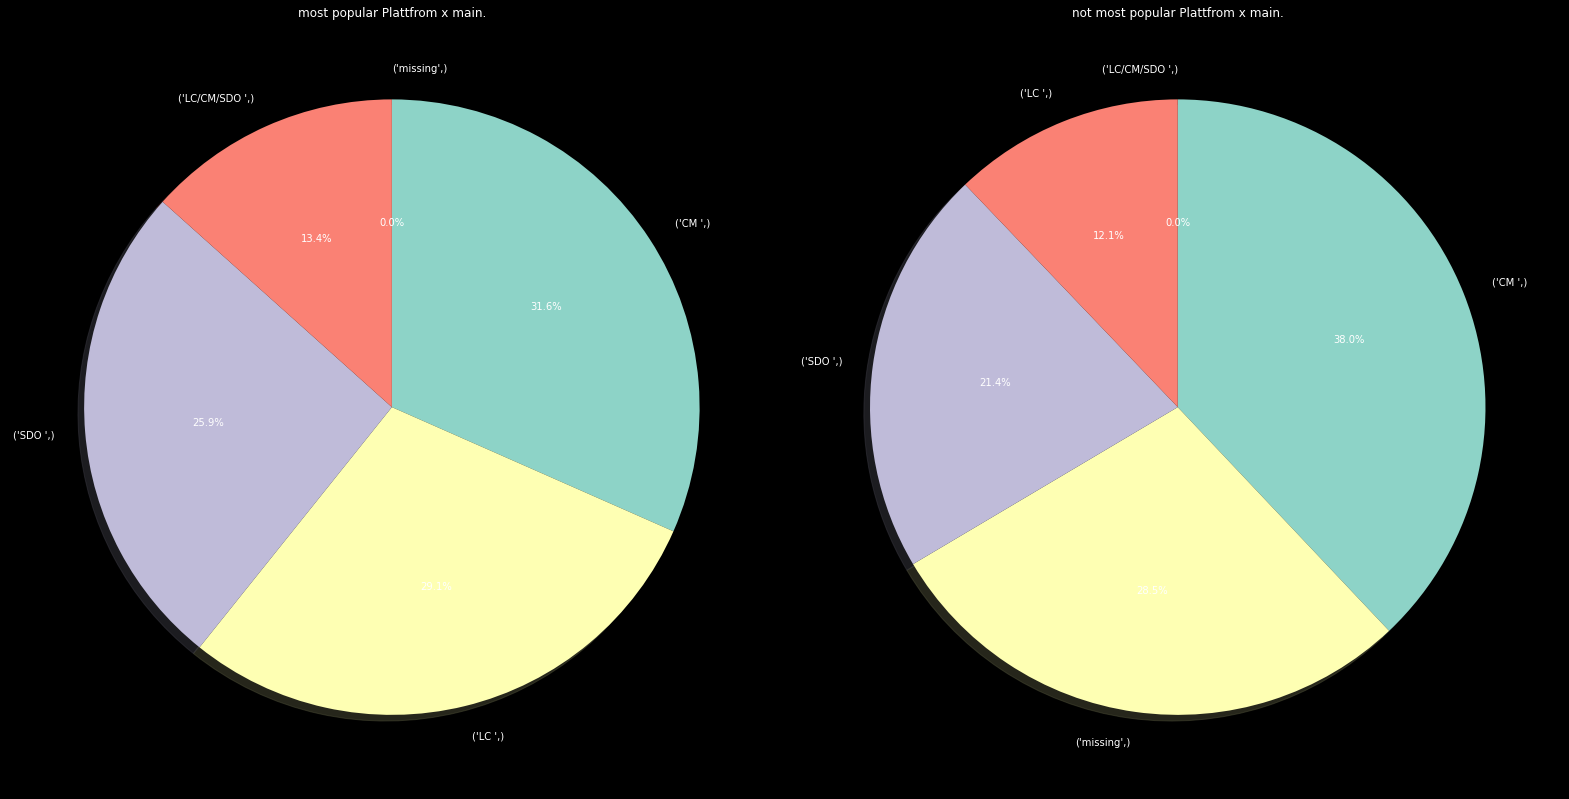

In [45]:
viz_main(top_10_plattform, under_10_plattform)

#### sub 

In [46]:
def create_vocab(sub) -> Dict[str, int]:
    word2count = {}
    for s in sub:
        s = s.strip()
        for ss in s.split():
            ss = ss.lower()
            if ss == "&": continue 
            if ss not in word2count:
                word2count[ss] = 1 
            else:
                word2count[ss] += 1 
    return word2count 

def viz_sub(high, low):
    fig, axes = plt.subplots(1, 2, figsize=(22, 12))
    ax = axes.ravel()
    
    x = df.loc[df["product"].isin(high), "sub"].to_list()
    word2count = create_vocab(x)
    word = WordCloud(width=1440, height=1100).generate_from_frequencies(word2count)
    ax[0].imshow(word)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("most popular Plattfrom x sub word")
    
    x = df.loc[df["product"].isin(low), "sub"].to_list()
    word2count = create_vocab(x)
    word = WordCloud(width=1440, height=1100).generate_from_frequencies(word2count)
    ax[1].imshow(word)
    ax[1].set_xticks([])
    ax[1].set_yticks([])    
    ax[1].set_title("not most popular Plattfrom x sub word")

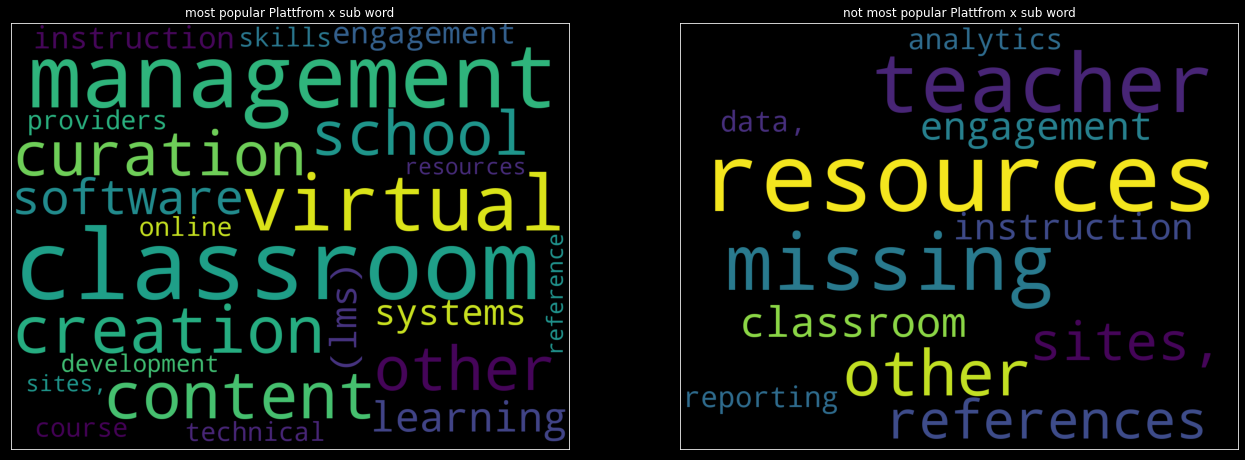

In [47]:
viz_sub(top_10_plattform, under_10_plattform)

In my opinion, the word used in schools on popular platforms. I think there are many specialized words on unpopular platforms. 

## Before and after the covid 
---

Get the platform with the highest growth rate from the average access value for each season. The front of the corona is divided into quarters, and the rear is divided into 2 and later. 

### Before the pandemic x Plattfrom 

In [48]:
df["quarter"] = df.time.dt.quarter 
display(df["quarter"].value_counts().to_frame().sort_index())

,quarter
1,242507
2,230811
3,184905
4,288322


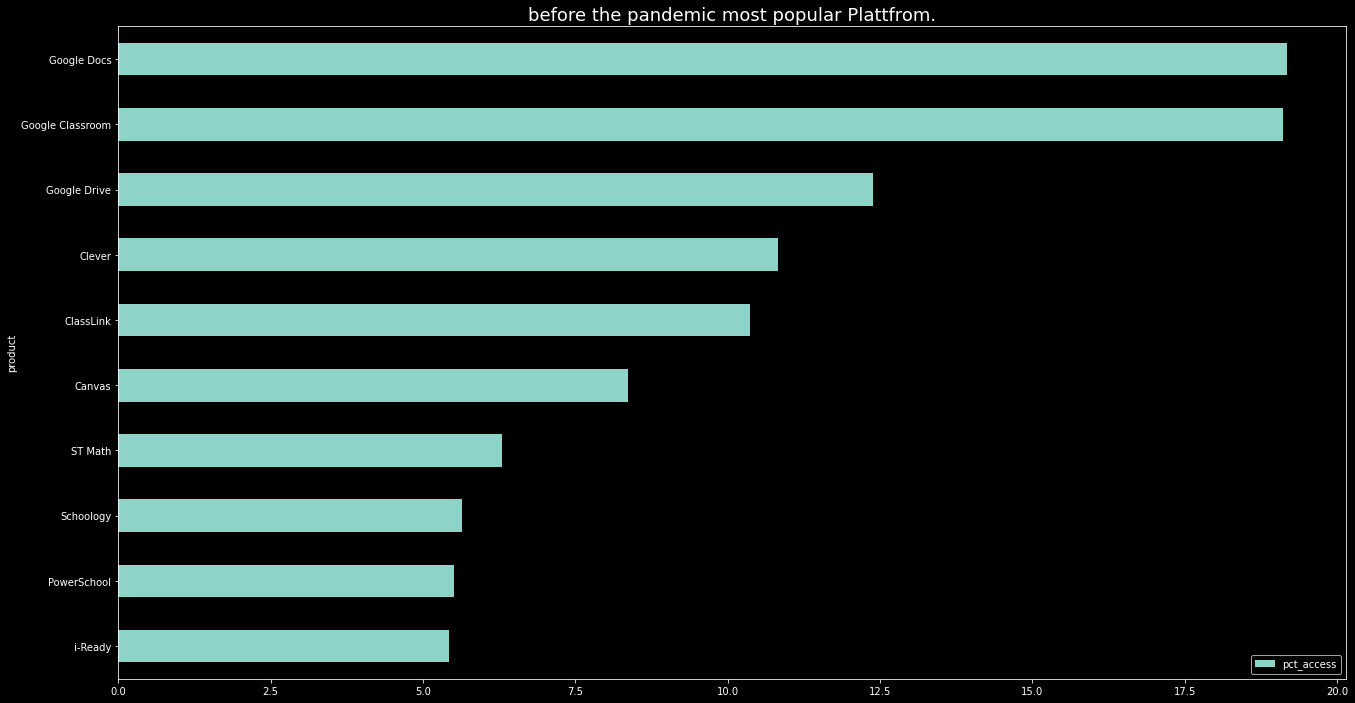

In [49]:
before_covid = df[df.quarter == 1]
before_covid = before_covid.pivot_table(values="pct_access", index="product", columns="quarter", aggfunc="mean")
before_covid.columns = ["pct_access"]

before_covid.sort_values("pct_access", ascending=False)[:10].sort_values("pct_access", ascending=True).plot(kind="barh", figsize=(22, 12))
plt.title("before the pandemic most popular Plattfrom.", fontsize=18)
plt.show()

### After the pandemic x Plattfrom 

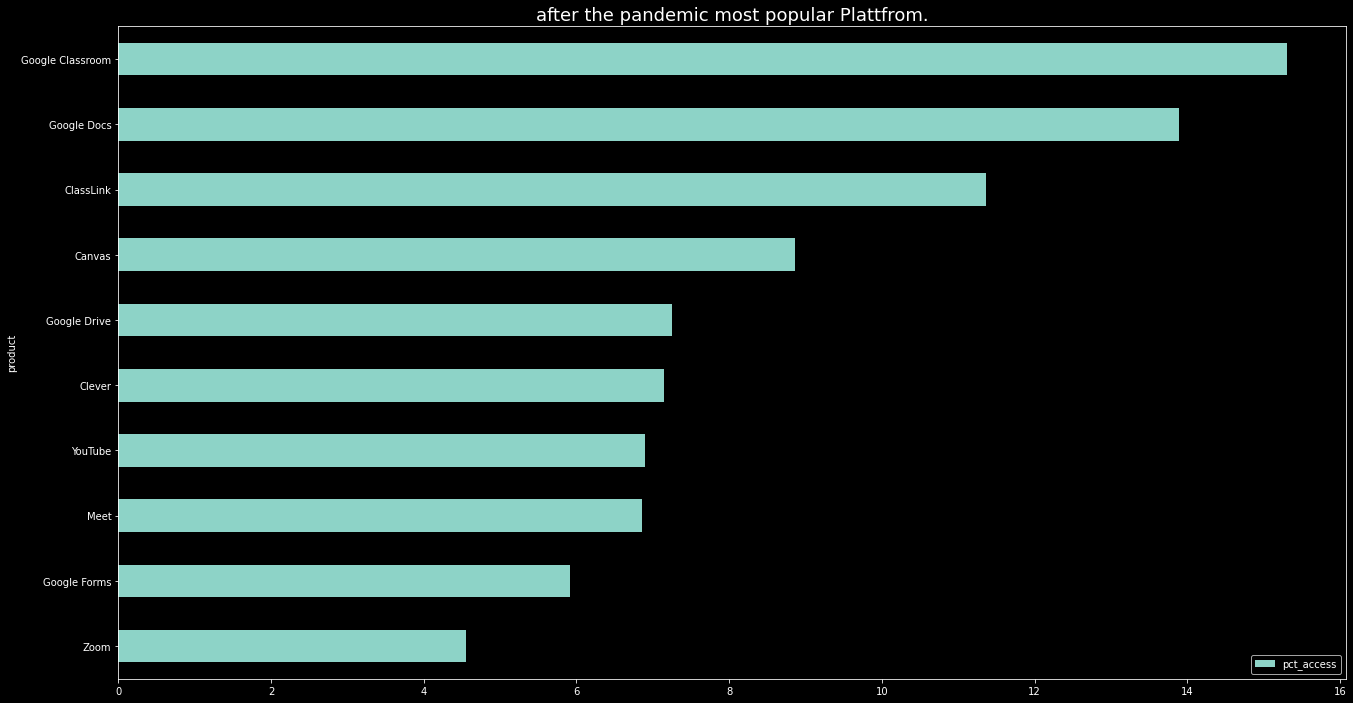

In [50]:
after_covid = df[df.quarter != 1]
after_covid = after_covid.groupby("product").mean().loc[:, ["pct_access"]]

after_covid.sort_values("pct_access", ascending=False)[:10].sort_values("pct_access", ascending=True).plot(kind="barh", figsize=(22, 12))
plt.title("after the pandemic most popular Plattfrom.", fontsize=18)
plt.show()

### Growth rate 

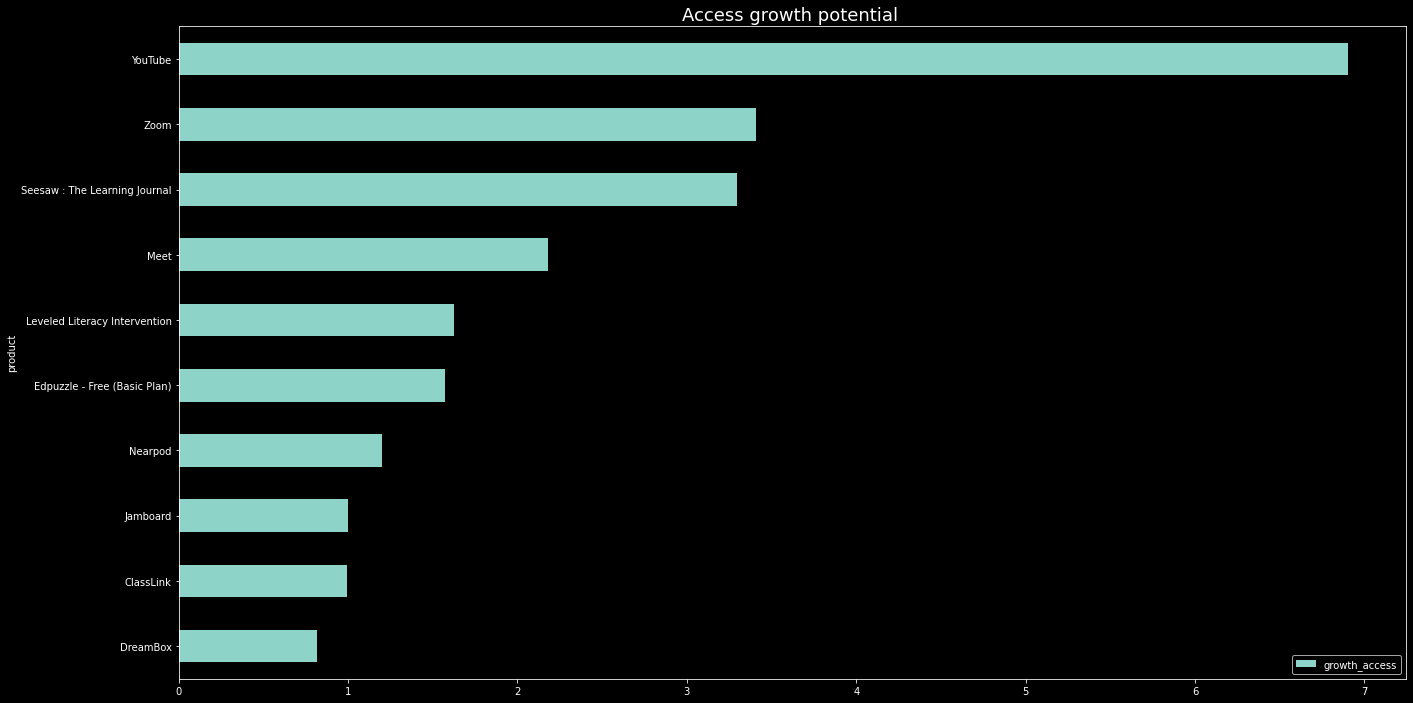

22174

In [51]:
growth = pd.merge(before_covid.rename(columns={"pct_access": "before_access"}), after_covid.rename(columns={"pct_access": "after_access"}), how="outer", left_index=True, right_index=True)
growth = growth.fillna(0)
growth["growth_access"] = growth["after_access"] - growth["before_access"]
growth = growth[["growth_access"]].sort_values("growth_access", ascending=False)[:10]

growth.sort_values("growth_access", ascending=True).plot(kind="barh", figsize=(22, 12))
plt.title("Access growth potential ", fontsize=18)
plt.show()

del before_covid, after_covid, growth 
gc.collect()

#### Observation...
* The google service is conservatively strong. 
* There are also platforms that have increased in demand after the corona. It seems that teleworking by video services is great. 

## Whether google 
---

### with google 

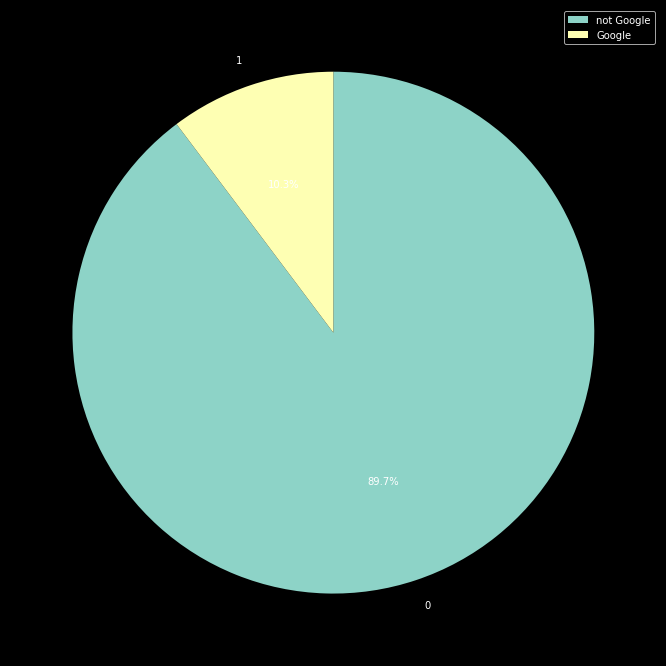

In [52]:
df["google"] = df["product"].apply(lambda x: x.find("Google") >= 0)
df["google"] = df["google"].apply(lambda x: 1 if x is True else 0)
google = df["google"].value_counts()

plt.figure(figsize=(12, 12))
plt.pie(x=google.values, labels=google.index, startangle=90, counterclock=False, autopct="%1.1f%%")
plt.legend(["not Google", "Google"])
plt.show()

8674

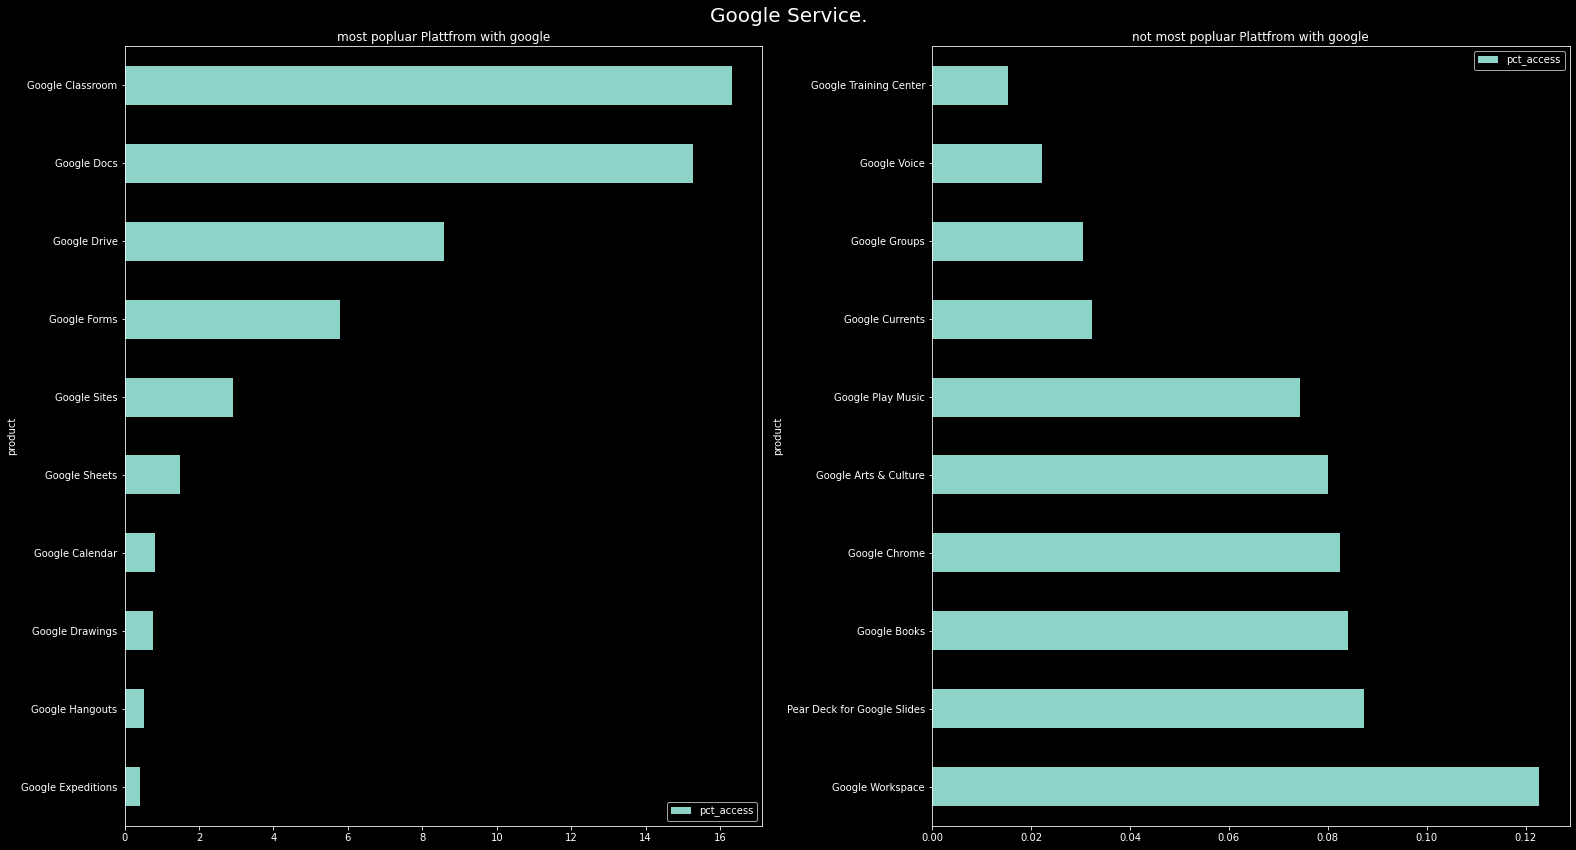

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(22, 12))
ax = axes.ravel()

google_service = df.loc[df["google"] == 1, ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=False)[:10]
google_service.sort_values("pct_access", ascending=True).plot(kind="barh", ax=ax[0])
ax[0].set_title("most popluar Plattfrom with google")

google_service = df.loc[df["google"] == 1, ["product", "pct_access"]].groupby("product").mean().sort_values("pct_access", ascending=True)[:10]
google_service.sort_values("pct_access", ascending=False).plot(kind="barh", ax=ax[1])
ax[1].set_title("not most popluar Plattfrom with google")

plt.suptitle("Google Service.", fontsize=20)
plt.tight_layout()

del google_service
gc.collect()

The difference between top and bottom is quite large 

### Comparison of transition 

In [54]:
def viz_transition_google():
    fig, axes = plt.subplots(1, 2, figsize=(22, 12))
    ax = axes.ravel()
    
    x = df.loc[df["google"] == 0, ["time", "pct_access"]].groupby("time").mean().sort_index()
    x.plot(ax=ax[0])
    ax[0].set_title("Not google x pct access.")
    
    x = df.loc[df["google"] == 1, ["time", "pct_access"]].groupby("time").mean().sort_index()
    x.plot(ax=ax[1])
    ax[1].set_title("is google x pct access.")
    
    plt.tight_layout()
    del x 
    gc.collect()
    

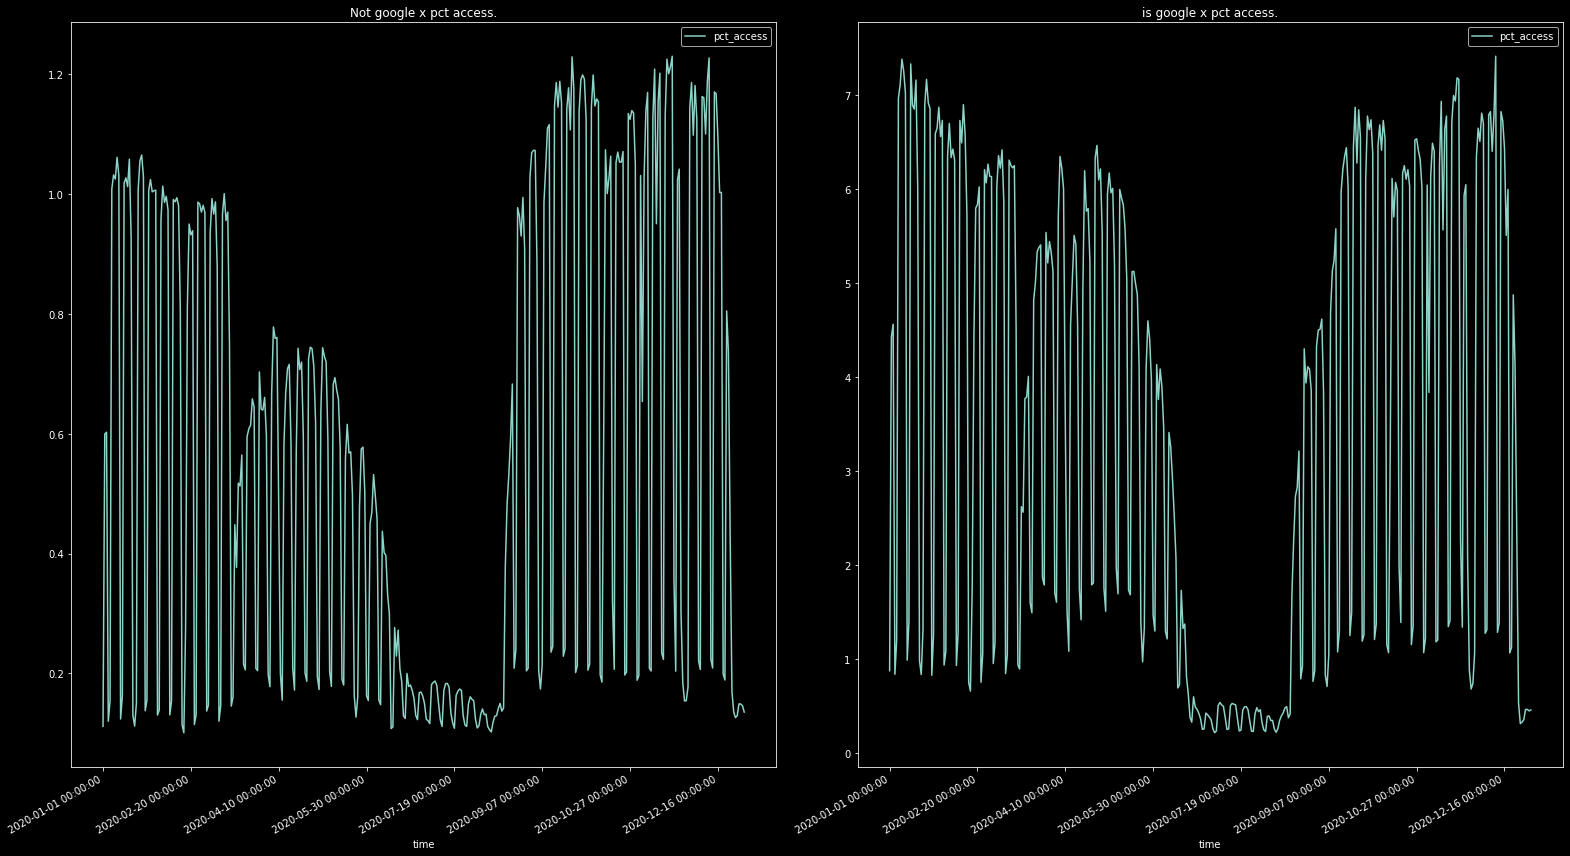

In [55]:
viz_transition_google()

Platforms other than google are on the rise after Corona. 

In [56]:
df.head()

,time,lp_id,pct_access,engagement_index,district_id,product,main,sub,state,locale,hispanic,reduced,pp_raw,week,quarter,google
0,2020-01-01,92844.0,0.010002,0.680000,6345,Typing.com,LC,Digital Learning Platforms,Massachusetts,Suburb,0.300049,0.339111,13000.0,2,1,0
1,2020-01-01,64838.0,0.010002,0.680000,6345,Starfall,LC,"Sites, Resources & Reference",Massachusetts,Suburb,0.300049,0.339111,13000.0,2,1,0
4,2020-01-01,32340.0,0.010002,0.110000,6345,Education Genius,missing,missing,Massachusetts,Suburb,0.300049,0.339111,13000.0,2,1,0
5,2020-01-01,95731.0,0.199951,40.959999,6345,Google Docs,LC,Content Creation & Curation,Massachusetts,Suburb,0.300049,0.339111,13000.0,2,1,1
6,2020-01-01,92918.0,0.010002,4.540000,6345,College Compass,missing,missing,Massachusetts,Suburb,0.300049,0.339111,13000.0,2,1,0


**Megha Goriya 19IT045**